# Part 1: preprocessing and exploration

Pandas is used to process The fake news corpus. Since content will be used for our models we drop any rows that don't have any content.

In [1]:
# Import standard libraries and set up NLTK resources
import re
import time
import nltk
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from cleantext import clean

# Download necessary TFIDFNLTK datasets (only run once)
nltk.download('punkt')
nltk.download('stopwords')

date_regex = re.compile(
    r'\b(?:'
      # Textual month (full or abbreviated) followed by day and year.
      r'(?:(?:Jan(?:uary)?|Feb(?:ruary)?|Mar(?:ch)?|Apr(?:il)?|May|Jun(?:e)?|'
      r'Jul(?:y)?|Aug(?:ust)?|Sep(?:tember)?|Oct(?:ober)?|Nov(?:ember)?|Dec(?:ember)?)\.?\s+\d{1,2}(?:,)?\s+\d{2,4})'
      r'|'
      # Numeric dates with day, month, and year in various orders (e.g., MM/DD/YYYY or DD-MM-YYYY).
      r'(?:(?:\d{1,2}[\/\-\.]\d{1,2}[\/\-\.]\d{2,4}))'
      r'|'
      # ISO-style date format: YYYY-MM-DD or YYYY/MM/DD.
      r'(?:(?:\d{4}[\/\-\.]\d{1,2}[\/\-\.]\d{1,2}))'
    r')\b', 
    re.IGNORECASE
)

# Define text processing functions
def clean_text(text):
    """Clean text by replacing dates, URLs, emails, numbers, etc."""
    text = date_regex.sub('<DATE>', text)
    cleaned = clean(text,
                    lower=True,
                    no_urls=True, replace_with_url="<URL>",
                    no_emails=True, replace_with_email="<EMAIL>",
                    no_numbers=True, replace_with_number="<NUM>",
                    no_currency_symbols=True, replace_with_currency_symbol="<CUR>",
                    no_punct=True, replace_with_punct="",
                    no_line_breaks=True,
                    normalize_whitespace=True,
                    fix_unicode=True,
                    no_digits=False,)
    return cleaned

def rmv_stopwords(tokens):
    """Remove English stopwords from a list of tokens."""
    stop_words = set(nltk.corpus.stopwords.words('english'))
    return [word for word in tokens if word not in stop_words]

def stem_tokens(tokens):
    """Apply Porter stemming to a list of tokens."""
    stemmer = nltk.PorterStemmer()
    return [stemmer.stem(word) for word in tokens]

def build_vocabulary(token_lists):
    """Build a vocabulary Counter from a list of token lists."""
    tokens = []
    for lst in token_lists:
        tokens.extend(lst)
    return Counter(tokens)


Since the GPL-licensed package `unidecode` is not installed, using Python's `unicodedata` package which yields worse results.
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\nikla\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nikla\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


We've implemented data processing functions to do the following:

    - Clean the text
    - Tokenize the text
    - Remove stopwords
    - Remove word variations with stemming
We use nltk and cleantext because it has built-in support for many of these operations.
We also use collections to import a counter, sklearn to import functions to split the dataset, chain to help with counting and matplotlib for visualizing.

In [2]:
# Read the sample dataset and drop rows without content
df = pd.read_csv("Datasets/news_sample.csv")
df = df.dropna(subset=['content']).head(10000).copy()
print(f"Initial dataset shape: {df.shape}")


Initial dataset shape: (250, 16)


We apply our data processing pipeline from task 1 on the 995k FakeNewsCorpus.

Since Pandas is slow on larger datasets we can use modin and ray to optimize pandas and allow for multithreading.

In [3]:
from nltk.tokenize.regexp import RegexpTokenizer

# Clean the content column
df['content'] = df['content'].apply(clean_text)

# Tokenize the cleaned text using a regular expression tokenizer
tokenizer = RegexpTokenizer(r'<[\w]+>|[\w]+')
df["tokenized"] = df.content.apply(tokenizer.tokenize)

# Build and print vocabulary size after cleaning
vocab = build_vocabulary(df.tokenized)
print("After cleaning:")
print(f"Vocabulary size: {len(vocab)}")


After cleaning:
Vocabulary size: 16594


In [4]:
# Remove stopwords and recalculate vocabulary size
df["tokenized"] = df.tokenized.apply(rmv_stopwords)
vocab_before = build_vocabulary(df.tokenized)
reduction_rate = ((len(vocab) - len(vocab_before)) / len(vocab)) * 100
print("\nAfter removing stopwords:")
print(f"Vocabulary size: {len(vocab_before)}")
print(f"Reduction rate: {reduction_rate:.2f}%")

# Apply stemming and calculate vocabulary reduction
df["tokenized"] = df.tokenized.apply(stem_tokens)
vocab_after = build_vocabulary(df.tokenized)
reduction_rate = ((len(vocab_before) - len(vocab_after)) / len(vocab_before)) * 100
print("\nAfter stemming:")
print(f"Vocabulary size: {len(vocab_after)}")
print(f"Reduction rate: {reduction_rate:.2f}%")



After removing stopwords:
Vocabulary size: 16462
Reduction rate: 0.80%

After stemming:
Vocabulary size: 11048
Reduction rate: 32.89%


### Task 2: clean 995000 rows

In [5]:
# Use Modin (with Ray engine) for large-scale data processing
import modin.config as modin_cfg
modin_cfg.Engine.put("ray")
import modin.pandas as mpd
import pandas as pd
import os
import ast


if not os.path.exists("Datasets/995000_rows_cleaned.csv"):
    # Read only needed columns and drop rows with missing values
    df_large = mpd.read_csv("Datasets/995000_rows.csv",  # Temporarily using 995000_rows instead of full dataset.
                            usecols=['content', 'type', 'title', 'domain'],
                            engine='c', dtype=str)
    df_large = df_large.dropna(subset=['content', 'type', 'title']).copy()

    # Define preprocess pipeline
    def preprocess_pipeline(text):
        cleaned_text = clean_text(text)
        tokens = tokenizer.tokenize(cleaned_text)
        reduced_tokens = rmv_stopwords(tokens)
        stemmed_tokens = stem_tokens(reduced_tokens)
        return stemmed_tokens

    chunk_size = 2000
    output_file = "Datasets/995000_rows_cleaned.csv"
    input_file = "Datasets/995000_rows.csv"

    # Write the header first
    with open(output_file, mode='w') as f:
        f.write("id,processed_content_tokens,processed_title_tokens,type,domain\n")

    # Process file in chunks, leveraging Modin parallelization inside each chunk
    reader = pd.read_csv(input_file, 
                        chunksize=chunk_size, 
                        dtype={'id': str, 'content': str, 'title': str, 'type': str, 'domain': str})

    for chunk_num, chunk in enumerate(reader, 1):
        # Convert chunk to Modin DataFrame for parallel processing
        modin_chunk = mpd.DataFrame(chunk)

        # Drop rows with NaN content, title type and domain
        modin_chunk.dropna(subset=['content', 'title', 'type', 'domain'], inplace=True)

        # Ensure content is string type
        modin_chunk['content'] = modin_chunk['content'].astype(str)
        modin_chunk['title'] = modin_chunk['title'].astype(str)
        modin_chunk['type'] = modin_chunk['type'].astype(str)
        modin_chunk['domain'] = modin_chunk['domain'].astype(str)

        # Parallelize token processing
        modin_chunk['processed_content_tokens'] = modin_chunk['content'].apply(preprocess_pipeline)
        modin_chunk['processed_title_tokens'] = modin_chunk['title'].apply(preprocess_pipeline)
        modin_chunk['type'] = modin_chunk['type'].apply(str)
        modin_chunk['domain'] = modin_chunk['domain'].apply(str)
        # Write processed data to filessed_title_tokens'].apply(ast.literal_eval)
        modin_chunk[['id', 'processed_content_tokens', 'processed_title_tokens', 'type', 'domain']].to_csv(
            output_file, mode='a', index=False, header=False
        )

        print(f"Processed chunk {chunk_num}")

# Clean text in title and content and measure time
# start = time.time()
# df_large['title'] = df_large.title.apply(clean_text)
# df_large['content'] = df_large.content.apply(clean_text)
# print(f"Time to clean the data: {time.time() - start:.2f} sec")

# Tokenization
# start = time.time()
# df_large['title'] = df_large.title.apply(tokenizer.tokenize)
# df_large['content'] = df_large.content.apply(tokenizer.tokenize)
# print(f"Time to tokenize the data: {(time.time() - start)/60:.2f} min")

# Remove stopwords
# start = time.time()
# df_large['title'] = df_large.title.apply(rmv_stopwords)
# df_large['content'] = df_large.content.apply(rmv_stopwords)
# print(f"Time to remove stopwords: {(time.time() - start)/60:.2f} min")

# Apply stemming
# start = time.time()
# df_large['title'] = df_large.title.apply(stem_tokens)
# df_large['content'] = df_large.content.apply(stem_tokens)
# print(f"Time to stem the data: {(time.time() - start):.2f} sec")


2025-03-27 00:01:59,532	INFO worker.py:1841 -- Started a local Ray instance.
Data types of partitions are different! Please refer to the troubleshooting section of the Modin documentation to fix this issue.


Number of rows in the dataset: 938632
Numerics in content: 7315444
Numerics in titles: 163248


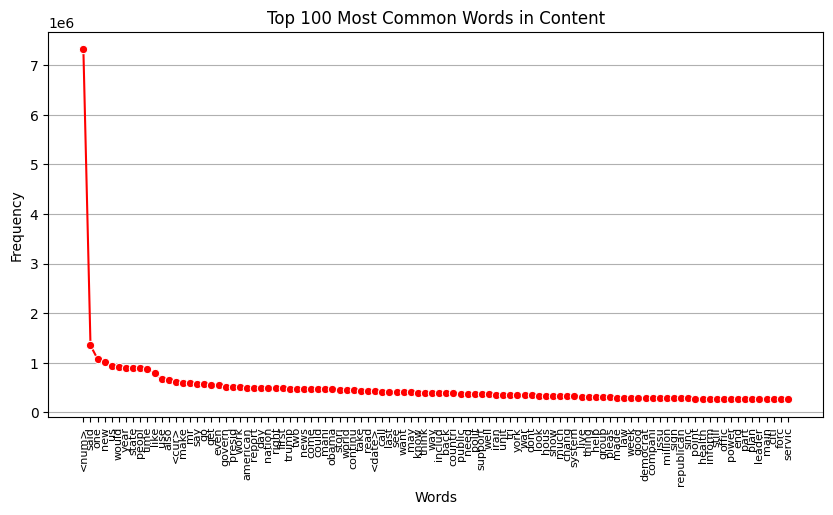

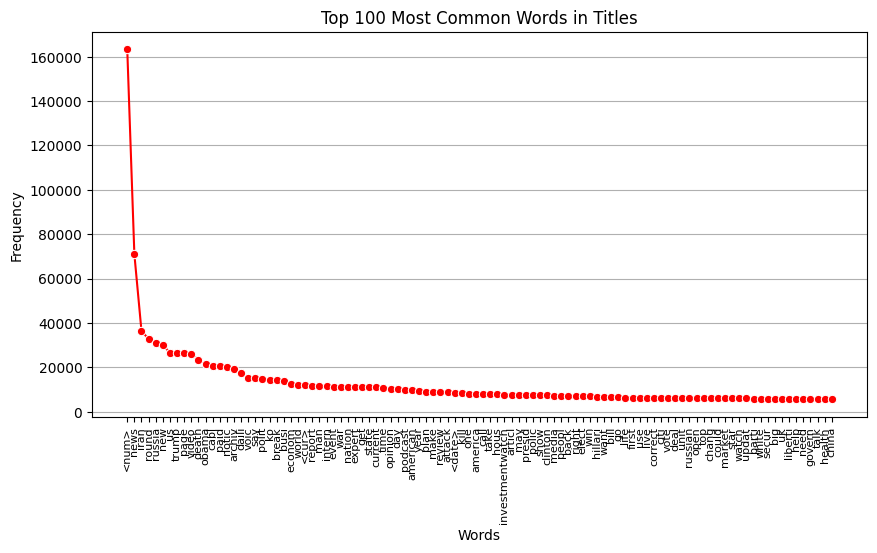

the groupby keys will be sorted anyway, although the 'sort=False' was passed. See the following issue for more details: https://github.com/modin-project/modin/issues/3571.


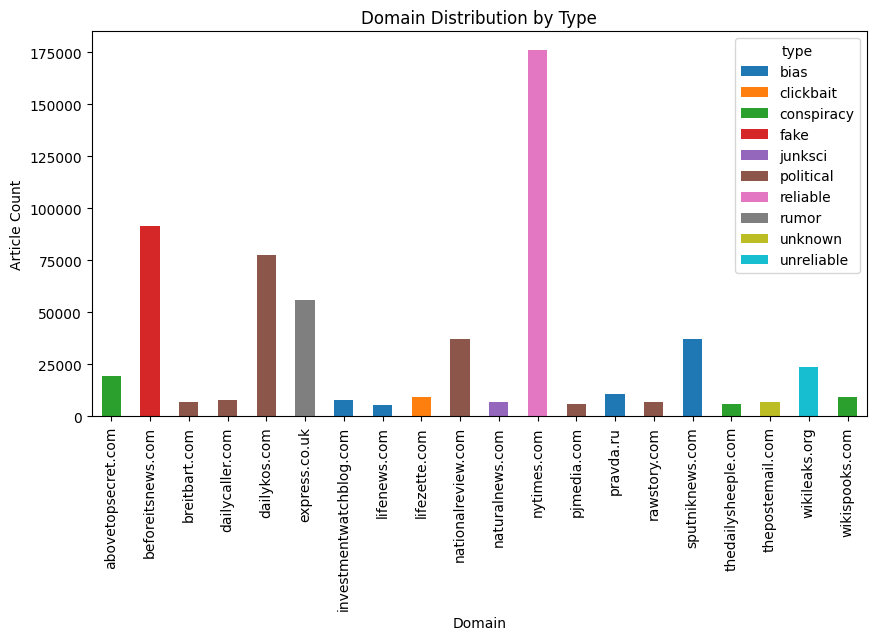

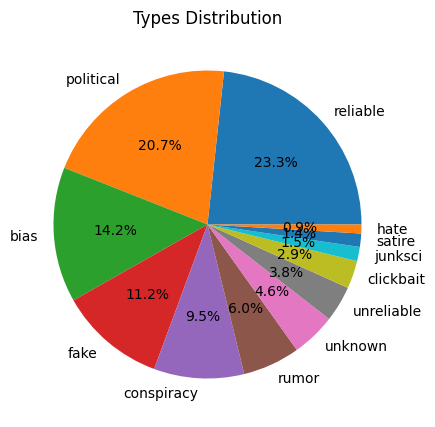

Number of dropped rows: 56368


In [6]:
# Define plotting functions
def plot_freq(counter, top_n, title):
    """Plot frequency distribution for the top_n words."""
    common = counter.most_common(top_n)
    words, freqs = zip(*common)
    
    plt.figure(figsize=(max(8, top_n * 0.1), 5))
    sns.lineplot(x=list(words), y=list(freqs), color='red', marker='o')
    plt.xticks(rotation=90, fontsize=8)
    plt.title(title)
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.grid(axis='y')
    plt.show()

def plot_domain_with_type(df):
    """Plot the distribution of article types for the top 20 domains."""
    top_domains = df['domain'].value_counts().head(20).index
    df_subset = df[df.domain.isin(top_domains)]
    df_grouped = df_subset.groupby(['domain', 'type']).size().unstack(fill_value=0)
    df_grouped.plot(kind='bar', stacked=True, figsize=(10,5), title='Domain Distribution by Type')
    plt.xlabel('Domain')
    plt.ylabel('Article Count')
    plt.show()

# Read the cleaned large dataset
df_large = mpd.read_csv("Datasets/995000_rows_cleaned.csv").copy()
df_large['processed_content_tokens'] = df_large['processed_content_tokens'].apply(ast.literal_eval)
df_large['processed_title_tokens'] = df_large['processed_title_tokens'].apply(ast.literal_eval)

#find number of rows in the dataset
print(f"Number of rows in the dataset: {df_large.shape[0]}")


# Build vocabularies for content and title (using original tokenized lists)
vocab_content = build_vocabulary(df_large['processed_content_tokens'])
vocab_title = build_vocabulary(df_large['processed_title_tokens'])
print("Numerics in content:", vocab_content.get("<num>", 0))
print("Numerics in titles:", vocab_title.get("<num>", 0))

# Plot the top 100 most frequent words in content and title
plot_freq(vocab_content, 100, "Top 100 Most Common Words in Content")
plot_freq(vocab_title, 100, "Top 100 Most Common Words in Titles")

# Plot domain distribution and article type
plot_domain_with_type(df_large)

# Plot the overall distribution of article types
plt.figure(figsize=(8,5))
df_large['type'].value_counts().plot.pie(autopct='%1.1f%%', title='Types Distribution')
plt.ylabel('')
plt.show()

# Print number of dropped rows
# (Assuming df_large was the result after dropping rows from the original dataset)
print(f"Number of dropped rows: {mpd.read_csv('Datasets/995000_rows.csv').shape[0] - df_large.shape[0]}")


In [7]:
# Re-join token lists into strings for saving
df_large['processed_content_tokens'] = df_large['processed_content_tokens'].apply(lambda tokens: ' '.join(tokens))
df_large['processed_title_tokens'] = df_large['processed_title_tokens'].apply(lambda tokens: ' '.join(tokens))

# Shutdown Ray to free memory
import ray
ray.shutdown()


In [8]:
from sklearn.model_selection import train_test_split

# Load cleaned dataset with selected columns
df_clean = pd.read_csv('Datasets/995000_rows_cleaned.csv', usecols=['processed_content_tokens', 'type', 'processed_title_tokens'], dtype=str).dropna()

# Map article types to binary labels (1: fake-related, 0: reliable)
type_mapping = {'fake': 1, 'conspiracy': 1, 'junksci': 1, 
                'reliable': 0}
df_clean['label'] = df_clean['type'].map(type_mapping)
df_clean = df_clean.dropna(subset=['label'])
df_clean['label'] = df_clean['label'].astype(int)

# Drop rows with missing content or title
df_clean = df_clean.dropna(subset=['processed_content_tokens', 'processed_title_tokens'])

# Split into training (80%), validation (10%), and test (10%) sets using stratification
train_df, temp_df = train_test_split(df_clean, test_size=0.2, random_state=42, stratify=df_clean['label'])
validation_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['label'])


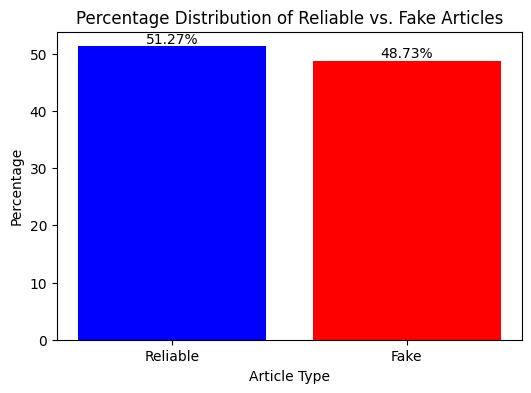

In [9]:
# Calculate percentage distribution
type_distribution = df_clean['label'].value_counts(normalize=True) * 100

# Bar plot of reliable vs. fake article percentages
plt.figure(figsize=(6,4))
bars = plt.bar([0, 1], type_distribution, tick_label=['Reliable', 'Fake'], color=['blue', 'red'])
for bar, pct in zip(bars, type_distribution):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{pct:.2f}%', ha='center', va='bottom')
plt.xlabel('Article Type')
plt.ylabel('Percentage')
plt.title('Percentage Distribution of Reliable vs. Fake Articles')
plt.show()

# Part 2: Simple model

In [10]:
# Extract features and labels for further use
content_train, title_train, y_train = train_df['processed_content_tokens'], train_df['processed_title_tokens'], train_df['label']
content_val, title_val, y_val = validation_df['processed_content_tokens'], validation_df['processed_title_tokens'], validation_df['label']
content_test, title_test, y_test = test_df['processed_content_tokens'], test_df['processed_title_tokens'], test_df['label']

print("Training set (content sample):")
print(content_train.head())
print("\nTraining set (title sample):")
print(title_train.head())

Training set (content sample):
139585    ['shock', 'said', 'yusuf', 'hassan', 'member',...
232748    ['close', 'imag', '<num>', '<num>', 'pope', 'f...
791586    ['common', 'sens', 'prepared', 'report', 'emp'...
862009    ['essenti', 'oil', 'use', 'oil', 'use', 'sinc'...
672106    ['everi', 'day', 'see', 'evid', 'caliph', 'glo...
Name: processed_content_tokens, dtype: object

Training set (title sample):
139585    ['kenya', 'rattl', 'shabab', 'turn', 'sight', ...
232748    ['homeless', 'vip', 'seat', 'pope', 'mass', 's...
791586    ['common', 'sens', 'prepared', 'report', 'emp'...
862009           ['way', 'use', 'essenti', 'oil', 'archiv']
672106    ['south', 'africa', '<num>', 'yearold', 'musli...
Name: processed_title_tokens, dtype: object


### Logistic regression content

In [11]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from scipy.sparse import hstack
from joblib import dump
from sklearn import metrics

# Build a pipeline for bag-of-words feature extraction and scaling
bow_pipeline_content = Pipeline([
    ('vectorizer', CountVectorizer(lowercase=False, max_features=5000, token_pattern=r'<[\w]+>|[\w]+')),
    ('scaler', StandardScaler(with_mean=False))
])

# create bag of word features (content only)
BoW_train_content = bow_pipeline_content.fit_transform(content_train)
BoW_val_content = bow_pipeline_content.transform(content_val)

# Train a simple logistic regression model using extra data (content only)
simple_model = LogisticRegression(max_iter=10000, random_state=42)
simple_model.fit(BoW_train_content, y_train)
y_pred_val = simple_model.predict(BoW_val_content)
print("Only content:")
print("Accuracy:", metrics.accuracy_score(y_val, y_pred_val))
print("F1 score:", metrics.f1_score(y_val, y_pred_val, average='binary'))

# Save pipeline and model
dump(bow_pipeline_content, "models/bow_pipeline_content.joblib")
dump(simple_model, "models/simple_model_content.joblib")


Only content:
Accuracy: 0.9393910963081109
F1 score: 0.9384292794510103


['models/simple_model_content.joblib']

### Logistic regression metadata features included (title)

In [12]:
# For combined content and title, concatenate content and title into one
content_title_train = content_train + " " + title_train
content_title_val = content_val + " " + title_val
content_title_test = content_test + " " + content_test

# Build a pipeline for bag-of-words feature extraction and scaling
bow_pipeline_content_title = Pipeline([
    ('vectorizer', CountVectorizer(lowercase=False, max_features=5000, token_pattern=r'<[\w]+>|[\w]+')),
    ('scaler', StandardScaler(with_mean=False))
])

# Create bag of word features (content and title)
BoW_train_content_title = bow_pipeline_content_title.fit_transform(content_title_train)
BoW_val_content_title = bow_pipeline_content_title.transform(content_title_val)

# Fit and predict
simple_model.fit(BoW_train_content_title, y_train)
y_pred_val = simple_model.predict(BoW_val_content_title)
print("\nContent and title:")
print("Accuracy:", metrics.accuracy_score(y_val, y_pred_val))
print("F1 score:", metrics.f1_score(y_val, y_pred_val))

# Save the simple model (combined version) # AND the fittet pipeline for reuse in the test.
dump(bow_pipeline_content_title, "models/bow_pipeline_content_title.joblib")
dump(simple_model, 'models/simple_model_content_title.joblib')


Content and title:
Accuracy: 0.9434019796406624
F1 score: 0.9421578732890669


['models/simple_model_content_title.joblib']

### Logistic regression content only with BBC articles

In [13]:
# Load extra reliable articles scraped from BBC
df_extra = pd.read_csv("Datasets/article_texts.csv", usecols=['article_text']).dropna()

# Process the extra articles similarly
df_extra['article_text'] = df_extra['article_text'].apply(clean_text)
df_extra['article_text'] = df_extra['article_text'].apply(tokenizer.tokenize)
df_extra['article_text'] = df_extra['article_text'].apply(rmv_stopwords)
df_extra['article_text'] = df_extra['article_text'].apply(stem_tokens)
df_extra['label'] = 0  # reliable articles labeled as 0

# Convert tokens back to strings
df_extra['article_text'] = df_extra['article_text'].apply(lambda tokens: ' '.join(tokens))

# Append extra reliable articles to training data
content_train_extra = pd.concat([content_train, df_extra['article_text']], ignore_index=True)
y_train_extra = pd.concat([y_train, df_extra['label']], ignore_index=True)

# Build a pipeline for bag-of-words feature extraction and scaling
bow_pipeline_content_extra = Pipeline([
    ('vectorizer', CountVectorizer(lowercase=False, max_features=5000, token_pattern=r'<[\w]+>|[\w]+')),
    ('scaler', StandardScaler(with_mean=False))
])

# create bag of word features (content only) (extra articles)
BoW_train_content_extra = bow_pipeline_content_extra.fit_transform(content_train_extra)
BoW_val_content_extra = bow_pipeline_content_extra.transform(content_val) # Not extra only for training data

# Train a simple logistic regression model using extra data (content only)
simple_model.fit(BoW_train_content_extra, y_train_extra)
y_pred_val = simple_model.predict(BoW_val_content_extra)
print("Only content:")
print("Accuracy:", metrics.accuracy_score(y_val, y_pred_val))
print("F1 score:", metrics.f1_score(y_val, y_pred_val, average='binary'))

# Save pipeline and model
dump(bow_pipeline_content_extra, "models/bow_pipeline_content_extra.joblib")
dump(simple_model, "models/simple_model_content_extra.joblib")

Only content:
Accuracy: 0.9394614626823662
F1 score: 0.93843181221822


['models/simple_model_content_extra.joblib']

# Part 3: Advanced model

In [14]:
# Function to plot a confusion matrix
from sklearn import metrics

def make_confusion_matrix(y_true, y_pred, model_name):
    """Plot a confusion matrix using seaborn heatmap."""
    cm = metrics.confusion_matrix(y_true, y_pred, labels=[1, 0])
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', 
                xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(model_name)
    plt.show()

In [15]:
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from joblib import dump
import time
from sklearn import metrics

# --- Helper functions for model training ---
def train_svm(x_train, y_train, x_val, model_name):
    start_time = time.time()
    svc = LinearSVC(max_iter=10000, dual=False, random_state=42)
    params = {'C': [0.1, 1, 10, 20, 50, 100]}
    grid = GridSearchCV(svc, params, cv=3, n_jobs=-1, scoring='f1', pre_dispatch=3)
    grid.fit(x_train, y_train)
    print(f"SVM training time: {(time.time() - start_time)/60:.2f} min")
    print("Best Parameters for SVM:", grid.best_params_)
    dump(grid, f'models/{model_name}.joblib')
    return grid.predict(x_val)

def train_naive_bayes(x_train, y_train, x_val, model_name):
    start_time = time.time()
    nb = MultinomialNB()
    params = {'alpha': [0.01, 0.1, 1, 10]}
    grid = GridSearchCV(nb, params, cv=3, n_jobs=-1, scoring='f1')
    grid.fit(x_train, y_train)
    print(f"Naive Bayes training time: {(time.time() - start_time)/60:.2f} min")
    print("Best Parameters for Naive Bayes:", grid.best_params_)
    dump(grid, f'models/{model_name}.joblib')
    return grid.predict(x_val)

def train_logistic(x_train, y_train, x_val, model_name):
    start_time = time.time()
    logistic = LogisticRegression(max_iter=10000, random_state=42)
    params = {'C': [0.1, 1, 10], 'solver': ['sag', 'saga']}
    grid = GridSearchCV(logistic, params, cv=3, n_jobs=-1, scoring='f1', pre_dispatch=3)
    grid.fit(x_train, y_train)
    print(f"Logistic regression training time: {(time.time() - start_time)/3600:.2f} hours")
    print("Best Parameters for Logistic Regression:", grid.best_params_)
    dump(grid, f'models/{model_name}.joblib')
    return grid.predict(x_val)

def train_gradient_boosting(x_train, y_train, x_val, model_name):
    start_time = time.time()
    from sklearn.ensemble import GradientBoostingClassifier
    gbc = GradientBoostingClassifier(random_state=42)
    params = {'n_estimators': [50, 100, 200],
              'learning_rate': [0.01, 0.1, 0.2],
              'max_depth': [3, 5, 7]}
    grid = GridSearchCV(gbc, params, cv=3, n_jobs=-1, scoring='f1')
    grid.fit(x_train, y_train)
    print(f"Gradient Boosting training time: {(time.time() - start_time)/60:.2f} min")
    print("Best Parameters for Gradient Boosting:", grid.best_params_)
    dump(grid, f'models/{model_name}.joblib')
    return grid.predict(x_val)

def train_random_forest(x_train, y_train, x_val, model_name):
    start_time = time.time()
    from sklearn.ensemble import RandomForestClassifier
    rf = RandomForestClassifier(random_state=42)
    params = {'n_estimators': [50, 100, 200],
              'max_depth': [None, 10, 20, 30]}
    grid = GridSearchCV(rf, params, cv=3, n_jobs=-1, scoring='f1')
    grid.fit(x_train, y_train)
    print(f"Random Forest training time: {(time.time() - start_time)/60:.2f} min")
    print("Best Parameters for Random Forest:", grid.best_params_)
    dump(grid, f'models/{model_name}.joblib')
    return grid.predict(x_val)

# --- TF-IDF feature extraction function using only content ---
def make_TFIDF(features, ngrams):
    tfidf_pipeline = Pipeline([
        ('vectorizer', TfidfVectorizer(lowercase=False, 
                                       max_features=features, 
                                       min_df=1, 
                                       max_df=0.9, 
                                       token_pattern=r'<[\w]+>|[\w]+',
                                       ngram_range=ngrams)),
        ('scaler', StandardScaler(with_mean=False))
    ])
    
    # Use only the content fields for the pipeline
    X_train = tfidf_pipeline.fit_transform(content_train, y_train)
    X_val   = tfidf_pipeline.transform(content_val)
    
    return X_train, X_val, tfidf_pipeline


In [16]:
# --- Evaluate advanced models using TF-IDF (1-gram) ---
X_train_tfidf, X_val_tfidf, tfidf_pipeline = make_TFIDF(3500, (1, 1))

print("Evaluating SVM with TF-IDF (1-gram):")
y_pred_svm = train_svm(X_train_tfidf, y_train, X_val_tfidf, 'svm_1gram')
print("SVM F1 score:", metrics.f1_score(y_val, y_pred_svm))
print("SVM Accuracy:", metrics.accuracy_score(y_val, y_pred_svm))

print("\nEvaluating Logistic Regression with TF-IDF (1-gram):")
y_pred_logistic = train_logistic(X_train_tfidf, y_train, X_val_tfidf, 'logistic_1gram')
print("Logistic Regression F1 score:", metrics.f1_score(y_val, y_pred_logistic))
print("Logistic Regression Accuracy:", metrics.accuracy_score(y_val, y_pred_logistic))

print("\nEvaluating Naive Bayes with TF-IDF (1-gram):")
y_pred_nb = train_naive_bayes(X_train_tfidf, y_train, X_val_tfidf, 'naive_bayes_1gram')
print("Naive Bayes F1 score:", metrics.f1_score(y_val, y_pred_nb))
print("Naive Bayes Accuracy:", metrics.accuracy_score(y_val, y_pred_nb))

print("\nEvaluating Gradient Boosting with TF-IDF (1-gram):")
y_pred_gb = train_gradient_boosting(X_train_tfidf, y_train, X_val_tfidf, 'gradient_boosting_1gram')
print("Gradient Boosting F1 score:", metrics.f1_score(y_val, y_pred_gb))
print("Gradient Boosting Accuracy:", metrics.accuracy_score(y_val, y_pred_gb))

print("\nEvaluating Random Forest with TF-IDF (1-gram):")
y_pred_rf = train_random_forest(X_train_tfidf, y_train, X_val_tfidf, 'random_forest_1gram')
print("Random Forest F1 score:", metrics.f1_score(y_val, y_pred_rf))
print("Random Forest Accuracy:", metrics.accuracy_score(y_val, y_pred_rf))

# --- Evaluate models using TF-IDF with 2-grams if desired ---
X_train_tfidf_2, X_val_tfidf_2, tfidf_pipeline_2gram  = make_TFIDF(3500, (2, 2))
dump(tfidf_pipeline_2gram, 'models/tfidf_pipeline_2gram.joblib')
print("\nEvaluating SVM with TF-IDF (2-gram):")
y_pred_svm_2 = train_svm(X_train_tfidf_2, y_train, X_val_tfidf_2, 'svm_2gram')
print("SVM (2-gram) F1 score:", metrics.f1_score(y_val, y_pred_svm_2))
print("SVM (2-gram) Accuracy:", metrics.accuracy_score(y_val, y_pred_svm_2))
dump(tfidf_pipeline_2gram, "models/tfidf_pipeline_2gram.joblib")


Evaluating SVM with TF-IDF (1-gram):
SVM training time: 6.02 min
Best Parameters for SVM: {'C': 100}
SVM F1 score: 0.9391992327978902
SVM Accuracy: 0.9405169582961955

Evaluating Logistic Regression with TF-IDF (1-gram):
Logistic regression training time: 0.98 hours
Best Parameters for Logistic Regression: {'C': 1, 'solver': 'sag'}
Logistic Regression F1 score: 0.9390281943611277
Logistic Regression Accuracy: 0.9403996810057701

Evaluating Naive Bayes with TF-IDF (1-gram):
Naive Bayes training time: 0.10 min
Best Parameters for Naive Bayes: {'alpha': 0.01}
Naive Bayes F1 score: 0.881431339249408
Naive Bayes Accuracy: 0.8837312942721771

Evaluating Gradient Boosting with TF-IDF (1-gram):
Gradient Boosting training time: 390.72 min
Best Parameters for Gradient Boosting: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200}
Gradient Boosting F1 score: 0.9546757092367943
Gradient Boosting Accuracy: 0.955481540554487

Evaluating Random Forest with TF-IDF (1-gram):
Random Forest traini

['models/tfidf_pipeline_2gram.joblib']


Content Model on Test Set:
Accuracy: 0.9384059670685369
F1 score: 0.9373479028486902


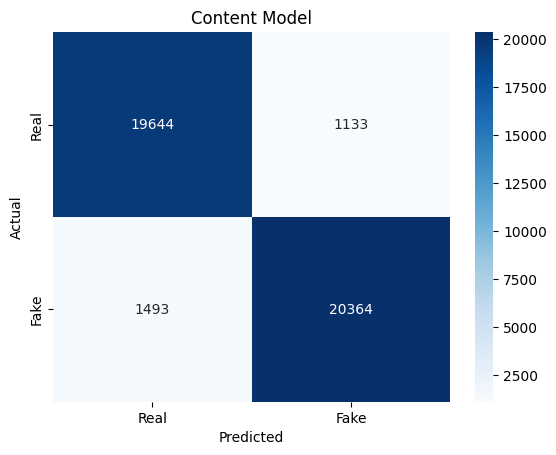

In [17]:
from joblib import load

# Load the pre-fitted pipeline and logistic regression model for content only
bow_pipeline_content = load("models/bow_pipeline_content.joblib")
simple_model = load("models/simple_model_content.joblib")

# Transform the test set using only the content data
BoW_test_content = bow_pipeline_content.transform(content_test)

# Evaluate the logistic regression model on the transformed test features
simple_pred_test = simple_model.predict(BoW_test_content)
print("\nContent Model on Test Set:")
print("Accuracy:", metrics.accuracy_score(y_test, simple_pred_test))
print("F1 score:", metrics.f1_score(y_test, simple_pred_test, average='binary'))

def make_confusion_matrix(y_true, y_pred, model_name):
    """Plot a confusion matrix using seaborn heatmap."""
    cm = metrics.confusion_matrix(y_true, y_pred, labels=[1, 0])
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', 
                xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(model_name)
    plt.show()
    
make_confusion_matrix(y_test, simple_pred_test, "Content Model")


# Part4 LIAR Dataset



Evaluation on LIAR dataset (Simple Model):
Accuracy: 0.4545341769011289
F1 score: 0.6072353729343457


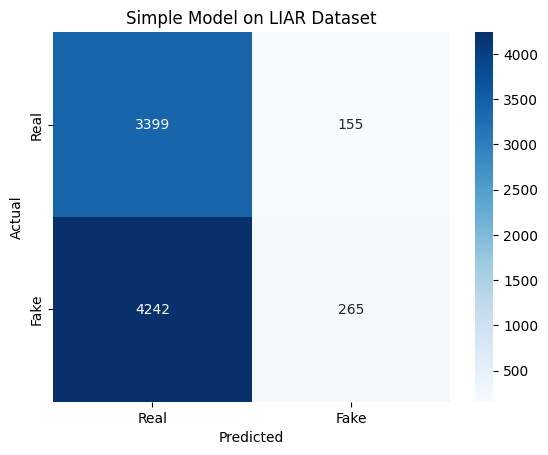


Evaluation on LIAR dataset (Advanced Model):
Accuracy: 0.4413844436174172
F1 score: 0.6117099249805984


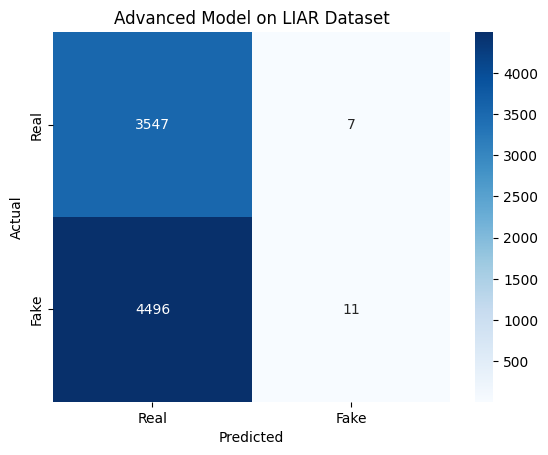

In [18]:
# Load LIAR dataset splits and concatenate them
liar_train = pd.read_csv('Datasets/train.tsv', sep='\t', header=None)
liar_val   = pd.read_csv('Datasets/valid.tsv', sep='\t', header=None)
liar_test  = pd.read_csv('Datasets/test.tsv', sep='\t', header=None)
liar_df = pd.concat([liar_train, liar_val, liar_test], ignore_index=True)

# Process the LIAR dataset (assume column 2 contains text)
liar_df[3] = liar_df[2].apply(clean_text)
liar_df[2] = liar_df[2].apply(tokenizer.tokenize)
liar_df[2] = liar_df[2].apply(rmv_stopwords)
liar_df[2] = liar_df[2].apply(stem_tokens)
liar_df[2] = liar_df[2].apply(lambda tokens: ' '.join(tokens))

# Filter for used labels and map to binary (example mapping)
labels_used = ['pants-fire', 'false', 'mostly-true', 'true']
liar_df = liar_df.dropna(subset=[1])
liar_df = liar_df[liar_df[1].isin(labels_used)]
liar_df[1] = liar_df[1].map({'pants-fire': 1, 'false': 1, 'mostly-true': 0, 'true': 0})
liar_df = liar_df.dropna(subset=[2])

# Build pipelines for LIAR evaluation with limited features (7000 combined)
liar_bow_pipeline = Pipeline([
    ('vectorizer', CountVectorizer(max_features=3500, token_pattern=r'<[\w]+>|[\w]+')),
    ('scaler', StandardScaler(with_mean=False))
])
# For combined features, create for content and title (here we use only column 2 as text)
liar_features = liar_df[2]
y_liar = liar_df[1]

tfidf_pipeline_simple = load("models/bow_pipeline_content.joblib")
liar_tfidf = tfidf_pipeline_simple.transform(liar_features)
simple_model_loaded = load("models/simple_model_content.joblib")
simple_pred_liar = simple_model_loaded.predict(liar_tfidf)

print("\nEvaluation on LIAR dataset (Simple Model):")
print("Accuracy:", metrics.accuracy_score(y_liar, simple_pred_liar))
print("F1 score:", metrics.f1_score(y_liar, simple_pred_liar))
make_confusion_matrix(y_liar, simple_pred_liar, "Simple Model on LIAR Dataset")

# Load the saved TF-IDF pipeline that was used for training the advanced model
tfidf_pipeline_2gram = load("models/tfidf_pipeline_2gram.joblib")

# Transform the LIAR dataset using the same pipeline
liar_tfidf = tfidf_pipeline_2gram.transform(liar_features)

# Load the advanced model and perform evaluation
advanced_model_loaded = load("models/gradient_boosting_1gram.joblib")
advanced_pred_liar = advanced_model_loaded.predict(liar_tfidf)

print("\nEvaluation on LIAR dataset (Advanced Model):")
print("Accuracy:", metrics.accuracy_score(y_liar, advanced_pred_liar))
print("F1 score:", metrics.f1_score(y_liar, advanced_pred_liar))
make_confusion_matrix(y_liar, advanced_pred_liar, "Advanced Model on LIAR Dataset")